In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import re
import warnings
warnings.filterwarnings('ignore')



#all data sets
ag_all_bh = pd.read_csv('Datasets/ag_all_bh.csv')
ag_col_bh = pd.read_csv('Datasets/ag_col_bh.csv')
ag_merge_bh = pd.read_csv('Datasets/ag_merge_bh.csv')
ag_col = pd.read_csv('Datasets/ag_col.csv')
ag_merge = pd.read_csv('Datasets/ag_merge.csv')
model_list = pd.read_csv('Datasets/model_list.csv')
#Si conversions
Parsec_to_m = 4.435e+7
G_const = 6.67430e-11
Msun_to_kg = 1.989e+30
#grouped data sets
MM_col_bh = pd.read_csv('Datasets/MS+MS_col_bh.csv')
MG_col_bh = pd.read_csv('Datasets/Giant+MS_col_bh.csv')
GG_col_bh = pd.read_csv('Datasets/Giant+Giant_col_bh.csv')

# model filtering code


In [2]:
def filter_models_by_rv(only_ms, model_list, max_rv):
    merged_df = pd.merge(only_ms, model_list, on='model', how='inner')
    
    filtered_df = merged_df[merged_df['rv'] < max_rv]
    
    return filtered_df

# sig grouping 

In [3]:
sig_MM_col_bh = MM_col_bh[MM_col_bh['mass_ratio']>=0.1]
sig_MG_col_bh = MG_col_bh[MG_col_bh['mass_ratio']>=0.1]
sig_GG_col_bh = GG_col_bh[GG_col_bh['mass_ratio']>=0.1]




# angular vel calculations

In [4]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!Verify units on this!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

def radius_from_mass_and_type(m, stype,
                              ms_relation=True,
                              ):
    """
    Return radius in solar radii for mass m (in M_sun) and stellar type stype.
    ms_relation: if True use the user-provided MS relation for types 0/1.
    giant_params: dict to control giant fallback: {'R0':10.0,'M0':1.5,'alpha':0.8}
    """
    # if giant_params is None:
    #     giant_params = {'R0':10.0, 'M0':1.5, 'alpha':0.8}

    # Treat types 0 and 1 as main sequence
    if stype in (0, 1) and ms_relation:
        mval = float(m) * Msun_to_kg
        if mval < 0.43:
            R = 0.892 * mval**0.8    # in Si
        else:
            R = 1.038 * mval**0.96
        return R


    # # Giants and other evolved types (2-6,8-9 etc) -> fallback empirical power-law:
    # if stype in (2,3,4,5,6,8,9):
    #     R0 = giant_params['R0']
    #     M0 = giant_params['M0']
    #     alpha = giant_params['alpha']
    #     R = R0 * (m / M0)**alpha
    #     # enforce a minimum (to avoid <=0)
    #     return max(R, 0.5)
    # # Naked helium MS etc -> fallback to scaled MS
    # if stype in (7,):
    #     # treat like small MS star
    #     return max(0.1, 0.8 * (m**0.8))

    # By default, fallback to an approximate MS-like scaling
    return 1.0 * (m**0.9)

In [5]:
def escape_velocity(m_large, r_large_Rsun):

    M = m_large *Msun_to_kg
    R = r_large_Rsun 
    return np.sqrt(2*G_const*M / R)

In [6]:
def angular_momentum_transfer(m_small, m_large, r_large_Rsun, k=0.4):

    # Escape velocity of larger star
    vesc = escape_velocity(m_large, r_large_Rsun)

    b = r_large_Rsun 

    # Angular momentum transfer from small star
    L = (m_small * Msun_to_kg) * vesc * b

    # Mass of combined object
    M_total = (m_small + m_large) * Msun_to_kg
    R_total = r_large_Rsun   #  assumption

    # Moment of inertia of combined object
    I_total = k * M_total * R_total**2

    # Angular velocities
    omega_final = L / I_total

    return L, vesc, b, omega_final


In [7]:
def add_collision_angular_momentum(df,
                                   m1_col='m1', m2_col='m2',
                                   t1_col='type1', t2_col='type2',
                                   
                                 ):

    df = df.copy()

    # compute radii
    df['R1_Rsun'] = df.apply(lambda row: radius_from_mass_and_type(row[m1_col], int(row[t1_col])), axis=1)
    df['R2_Rsun'] = df.apply(lambda row: radius_from_mass_and_type(row[m2_col], int(row[t2_col])), axis=1)

    # identify larger and smaller by mass (in case not ordered)
    df['large_mass'] = np.where(df[m1_col] >= df[m2_col], df[m1_col], df[m2_col])
    df['small_mass'] = np.where(df[m1_col] >= df[m2_col], df[m2_col], df[m1_col])
    df['large_type'] = np.where(df[m1_col] >= df[m2_col], df[t1_col], df[t2_col]).astype(int)
    df['small_type'] = np.where(df[m1_col] >= df[m2_col], df[t2_col], df[t1_col]).astype(int)
    df['R_large_Rsun'] = np.where(df[m1_col] >= df[m2_col], df['R1_Rsun'], df['R2_Rsun'])
    df['R_small_Rsun'] = np.where(df[m1_col] >= df[m2_col], df['R2_Rsun'], df['R1_Rsun'])



    L_list = []
    vesc_list = []
    b_list = []
    omega_list = []


    for i, row in df.iterrows():
        L, vesc, b, omega_f = angular_momentum_transfer(row['small_mass'], row['large_mass'], row['R_large_Rsun'])
        L_list.append(L)
        vesc_list.append(vesc)
        b_list.append(b)
        omega_list.append(omega_f)



    df['L_SI'] = L_list
    df['v_escape_large_m_s'] = vesc_list
    df['impact_b_m'] = b_list
    df['omega_f'] = omega_list


    return df

# testing code

In [8]:
ag_col_bh

,time_x,collision_type,idm,mm,id1,m1,id2,m2,r_x,typem,...,r_y,binary,ID,zams_m,m_progenitor,bh_mass,bh_spin,birth_kick,bbh_merger,model
0,11.565179,single-single,1680002,33.8986,1680001,33.7704,470820,0.129842,0.038822,4,...,0.191185,0,1680002,0.000000,17.89330,16.09650,0.0,1.00000,0,data\N16rv0.5rg2.0Z0.002
1,7.978654,single-single,1680061,133.8740,1680060,179.9130,299190,0.394966,0.013368,4,...,0.137582,1,1680061,0.000000,33.00390,29.70350,0.0,0.00000,0,data\N16rv0.5rg2.0Z0.002
2,3.710148,single-single,1680133,110.5980,1680132,110.4200,261872,0.179723,0.025530,4,...,0.144856,1,1680133,0.000000,35.19190,31.67270,0.0,0.00000,0,data\N16rv0.5rg2.0Z0.002
3,4.100341,single-single,1680220,41.3707,1680219,41.2697,328483,0.105145,0.052498,4,...,0.069415,0,1680220,0.341818,34.12200,30.70980,0.0,1.00000,0,data\N16rv0.5rg2.0Z0.002
4,3.849036,single-single,1680292,52.0011,1680291,51.8734,137163,0.133144,0.041029,4,...,0.034394,0,1680292,0.169725,40.61420,36.55280,0.0,1.00000,1,data\N16rv0.5rg2.0Z0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25558,7.467068,single-single,867397,27.4788,27397,27.2059,34148,0.274166,0.809076,4,...,0.809076,0,867397,1.377720,29.83110,12.91490,0.0,196.38100,0,data\N8.0rv4.0rg8.0Z0.002
25559,8.195550,single-single,935010,21.1569,95010,21.0637,260784,0.094146,1.787344,4,...,1.787344,0,935010,0.376952,29.08860,11.89070,0.0,89.37041,0,data\N8.0rv4.0rg8.0Z0.002
25560,8.195550,single-single,1021125,23.4548,239877,23.3603,181125,0.095204,2.219268,4,...,2.219268,0,1021125,0.000000,28.60760,11.48710,0.0,149.45210,0,data\N8.0rv4.0rg8.0Z0.002
25561,6.479118,single-single,901838,26.2744,61838,26.0639,69692,0.210457,0.995484,1,...,1.914572,0,901838,58.609600,8.76791,7.63069,0.0,1.00000,0,data\N8.0rv4.0rg8.0Z0.02


In [9]:
only_ms = sig_MM_col_bh


In [10]:
only_ms = add_collision_angular_momentum(only_ms,
                                   m1_col='m1', m2_col='m2',
                                   t1_col='type1', t2_col='type2',
                                   )

In [11]:
model_list

,N,rv,rg,Z,model_name,path
0,16.0,0.5,2.0,0.0020,N16rv0.5rg2.0Z0.002,data\N16rv0.5rg2.0Z0.002
1,16.0,0.5,2.0,0.0200,N16rv0.5rg2.0Z0.02,data\N16rv0.5rg2.0Z0.02
2,16.0,0.5,20.0,0.0020,N16rv0.5rg20.0Z0.002,data\N16rv0.5rg20.0Z0.002
3,16.0,0.5,20.0,0.0200,N16rv0.5rg20.0Z0.02,data\N16rv0.5rg20.0Z0.02
4,16.0,0.5,8.0,0.0020,N16rv0.5rg8.0Z0.002,data\N16rv0.5rg8.0Z0.002
...,...,...,...,...,...,...
140,8.0,4.0,20.0,0.0020,N8.0rv4.0rg20.0Z0.002,data\N8.0rv4.0rg20.0Z0.002
141,8.0,4.0,20.0,0.0200,N8.0rv4.0rg20.0Z0.02,data\N8.0rv4.0rg20.0Z0.02
142,8.0,4.0,8.0,0.0002,N8.0rv4.0rg8.0Z0.0002,data\N8.0rv4.0rg8.0Z0.0002
143,8.0,4.0,8.0,0.0020,N8.0rv4.0rg8.0Z0.002,data\N8.0rv4.0rg8.0Z0.002


In [12]:
only_ms

,q,type,pm,time_x,collision_type,idm,mm,id1,m1,id2,...,large_mass,small_mass,large_type,small_type,R_large_Rsun,R_small_Rsun,L_SI,v_escape_large_m_s,impact_b_m,omega_f
49,1.0,MS,50.0,4.483203,binary-binary,2495162,70.0363,815162,42.3842,1652038,...,42.3842,27.65210,1,1,4.623838e+30,3.068639e+30,1.254589e+58,0.000049,4.623838e+30,1.053121e-35
51,1.0,MS,50.0,3.712757,single-single,2517316,22.9098,1265599,17.6536,837316,...,17.6536,5.25624,1,1,1.994558e+30,6.233542e+29,1.010846e+57,0.000048,1.994558e+30,1.394039e-35
54,1.0,MS,50.0,7.819484,binary-binary,2668089,31.5163,988089,22.4318,1615845,...,22.4318,9.08451,1,1,2.510246e+30,1.054038e+30,2.209336e+57,0.000049,2.510246e+30,1.398296e-35
68,1.0,MS,50.0,5.986513,single-single,1693275,28.6789,343087,18.9531,13275,...,18.9531,9.72580,1,1,2.135304e+30,1.125369e+30,2.005236e+57,0.000049,2.135304e+30,1.927474e-35
169,1.0,MS,50.0,4.046539,single-single,2022420,54.5011,657269,45.7778,342420,...,45.7778,8.72329,1,1,4.978694e+30,1.013771e+30,4.268109e+57,0.000049,4.978694e+30,3.971043e-36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3087,1.0,MS,100.0,2.416617,binary-single,953147,97.0969,248388,80.1345,113147,...,80.1345,16.96240,1,1,8.522235e+30,1.919528e+30,1.436626e+58,0.000050,8.522235e+30,2.560570e-36
3110,1.0,MS,50.0,13.774543,binary-single,878427,32.5116,1172981,24.7757,38426,...,24.7757,7.73585,1,1,2.761542e+30,9.033467e+29,2.073800e+57,0.000049,2.761542e+30,1.051311e-35
3150,1.0,MS,50.0,4.740752,single-single,965578,29.8330,158284,25.2885,125578,...,25.2885,4.54455,1,1,2.816391e+30,5.420982e+29,1.242994e+57,0.000049,2.816391e+30,6.602231e-36
3163,1.0,MS,50.0,8.745689,single-single,899383,23.2204,59383,20.1264,109912,...,20.1264,3.09400,1,1,2.262050e+30,3.747885e+29,6.765883e+56,0.000049,2.262050e+30,7.157405e-36


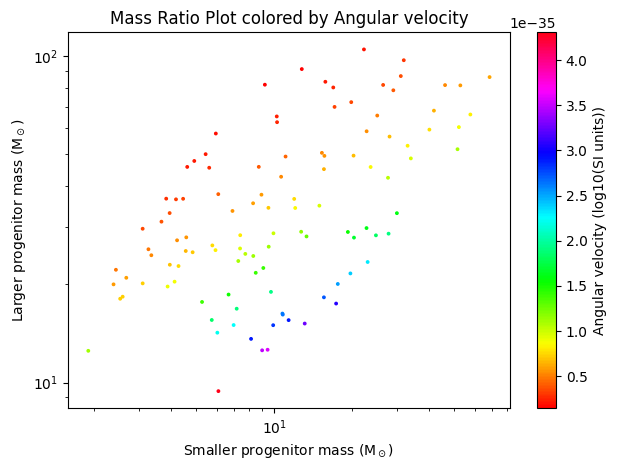

In [20]:
col_plot = only_ms.copy()

plt.figure()
sc = plt.scatter(col_plot['small_mass'], col_plot['large_mass'], c=col_plot['omega_f'],cmap='hsv', alpha=1, s=3)
plt.xlabel('Smaller progenitor mass (M$_\odot$)')
plt.ylabel('Larger progenitor mass (M$_\odot$)')
plt.yscale('log')
plt.xscale('log')
plt.title('Mass Ratio Plot colored by Angular velocity')
cb = plt.colorbar(sc); cb.set_label('Angular velocity (log10(SI units))')
plt.tight_layout()
plt.show()

In [19]:
1/(10*24*60*60)

1.1574074074074074e-06